# Model Rekomondasi

### Persiapaan Data

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.preprocessing import LabelEncoder
from scipy.sparse import hstack


In [2]:
def prepare_datasets(corpus, labels, test_data_proportion=0.3, random_state=42):
    train_X, test_X, train_Y, test_Y = train_test_split(corpus, labels,
                                                        test_size=test_data_proportion,
                                                        random_state=random_state)
    return train_X, test_X, train_Y, test_Y
    
def tfidf_extractor(corpus, ngram_range=(1,2)):
    vectorizer = TfidfVectorizer(min_df=1,
                                norm='l2',
                                smooth_idf=True,
                                use_idf=True,
                                ngram_range=ngram_range)
    features = vectorizer.fit_transform(corpus)
    return vectorizer, features

def bow_extractor(corpus, ngram_range=(1,1)):
    vectorizer = CountVectorizer(min_df=1, ngram_range=ngram_range)
    features = vectorizer.fit_transform(corpus)
    return vectorizer, features

In [3]:
df = pd.read_csv('sentiment_5400.csv')
df.head(10)

,content,sentimen
0,bogor keluarga fw 22 perempuan dibunuh pacarny...,negatif
1,khoiri 52 warga dusun blimbing desa parerejo k...,negatif
2,polisi menangkap andrea cw inggris chansler am...,negatif
3,wakil ketua umum pan yandri susanto capres ani...,negatif
4,pria medan satria kota bekasi terluka lehernya...,negatif
5,kpu ri menilai surat suara taipei taiwan surat...,negatif
6,jet jet tempur israel melancarkan serangan uda...,negatif
7,rumah milik mf 16 remaja diduga mencekik bocah...,negatif
8,calon presiden ganjar pranowo relawannya ikuta...,negatif
9,calon wakil presiden cawapres nomor urut 1 muh...,negatif


In [4]:
# Split data
x_train, x_test, y_train, y_test = prepare_datasets(df['content'], df['sentimen'], test_data_proportion=0.3)


In [5]:
# Convert text labels to numerical labels
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# Ensure the lengths match after splitting
y_train_encoded = y_train_encoded[:len(x_train)]
y_test_encoded = y_test_encoded[:len(x_test)]


In [6]:
# TF-IDF Vectorization
tfidf_vectorizer, tfidf_train_features = tfidf_extractor(x_train)
tfidf_test_features = tfidf_vectorizer.transform(x_test)

# Bag of Words (BoW) features
count_vectorizer, count_train_features = bow_extractor(x_train)
count_test_features = count_vectorizer.transform(x_test)

# Combine TF-IDF and BoW features
combined_train_features = hstack([tfidf_train_features, count_train_features])
combined_test_features = hstack([tfidf_test_features, count_test_features])

In [7]:
# TF-IDF Features
print("Jumlah fitur TF-IDF:", tfidf_train_features.shape[1])

# Bag of Words (BoW) Features
print("Jumlah fitur Bag of Words:", count_train_features.shape[1])

# Combined Features
print("Jumlah fitur gabungan:", combined_train_features.shape[1])

Jumlah fitur TF-IDF: 245316
Jumlah fitur Bag of Words: 26266
Jumlah fitur gabungan: 271582


### Model Naiye Bayes

In [8]:
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import seaborn as sns

In [9]:
# Define function to train and evaluate Naive Bayes classifier
def train_and_evaluate(classifier, train_features, train_labels, test_features, test_labels):
    # Train the classifier
    classifier.fit(train_features, train_labels)
    
    # Predictions
    predictions = classifier.predict(test_features)
    
    # Calculate accuracy
    accuracy = accuracy_score(test_labels, predictions)
    
    # Calculate F1 score
    f1 = f1_score(test_labels, predictions, average='weighted')
    
    # Classification report
    report = classification_report(test_labels, predictions, target_names=label_encoder.classes_)
    
    # Confusion matrix
    matrix = confusion_matrix(test_labels, predictions)
    
    return accuracy * 100, f1 * 100, report, matrix

In [10]:
# Function to plot confusion matrix
def plot_confusion_matrix(matrix, labels):
    plt.figure(figsize=(8, 6))
    sns.heatmap(matrix, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

#### Tanpa Parameter

In [11]:
# Initialize Naive Bayes classifier
model_naiye_tanpa_parameter = MultinomialNB()

# Train and evaluate on Bag of Words (BoW) features
bow_accuracy, bow_f1,bow_report,bow_matrix = train_and_evaluate(model_naiye_tanpa_parameter , count_train_features, y_train_encoded, count_test_features, y_test_encoded)




In [12]:
print("Bag of Words (BoW) Features:")
print("Accuracy: {:.2f}%".format(bow_accuracy))
print("F1 Score: {:.2f}%".format(bow_f1))
print("Classification Report:\n", bow_report)
print("Confusion Matrix:\n", bow_matrix)

Bag of Words (BoW) Features:
Accuracy: 78.27%
F1 Score: 78.07%
Classification Report:
               precision    recall  f1-score   support

     negatif       0.80      0.74      0.77       575
      netral       0.85      0.69      0.76       508
     positif       0.72      0.92      0.81       537

    accuracy                           0.78      1620
   macro avg       0.79      0.78      0.78      1620
weighted avg       0.79      0.78      0.78      1620

Confusion Matrix:
 [[427  42 106]
 [ 78 348  82]
 [ 26  18 493]]


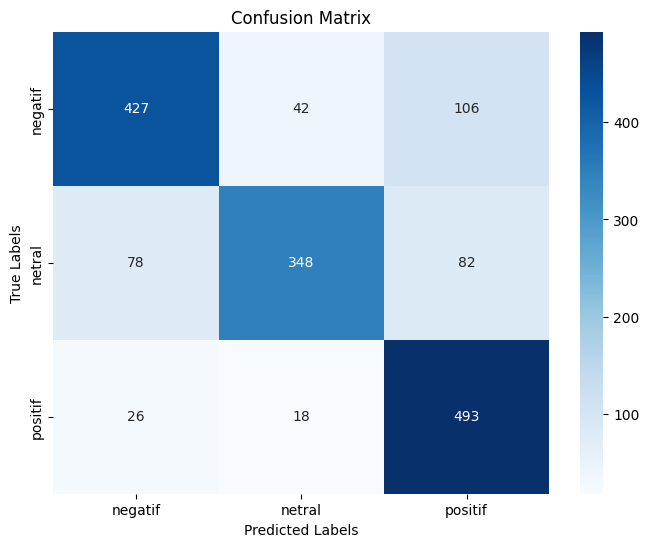

In [13]:
# Plot confusion matrix
plot_confusion_matrix(bow_matrix, label_encoder.classes_)

### Tuning GridCV

In [14]:
# # Define the parameter grid
# param_grid = {'alpha': [0.1, 0.5, 1.0, 5.0, 10.0]}

# # Initialize GridSearchCV
# grid_search = GridSearchCV(model_naiye_tanpa_parameter, param_grid, cv=5, scoring='accuracy')

# # Fit the grid search to the data
# grid_search.fit(count_train_features, y_train_encoded)

# # Get the best parameter
# best_alpha = grid_search.best_params_['alpha']
# print("Best alpha:", best_alpha)

# # Get the best model
# best_model = grid_search.best_estimator_
# print("Best alpha:", best_model)

#### Pakai Paramater

In [15]:
# Initialize Naive Bayes classifier
model_naiye_parameter = MultinomialNB(alpha=0.1,fit_prior=True)


# Train and evaluate on Bag of Words (BoW) features
bow_accuracy, bow_f1,bow_report,bow_matrix = train_and_evaluate(model_naiye_parameter , count_train_features, y_train_encoded, count_test_features, y_test_encoded)


In [16]:
print("Bag of Words (BoW) Features:")
print("Accuracy: {:.2f}%".format(bow_accuracy))
print("F1 Score: {:.2f}%".format(bow_f1))
print("Classification Report:\n", bow_report)
print("Confusion Matrix:\n", bow_matrix)

Bag of Words (BoW) Features:
Accuracy: 80.06%
F1 Score: 79.86%
Classification Report:
               precision    recall  f1-score   support

     negatif       0.80      0.78      0.79       575
      netral       0.89      0.69      0.77       508
     positif       0.75      0.93      0.83       537

    accuracy                           0.80      1620
   macro avg       0.81      0.80      0.80      1620
weighted avg       0.81      0.80      0.80      1620

Confusion Matrix:
 [[451  32  92]
 [ 83 349  76]
 [ 27  13 497]]


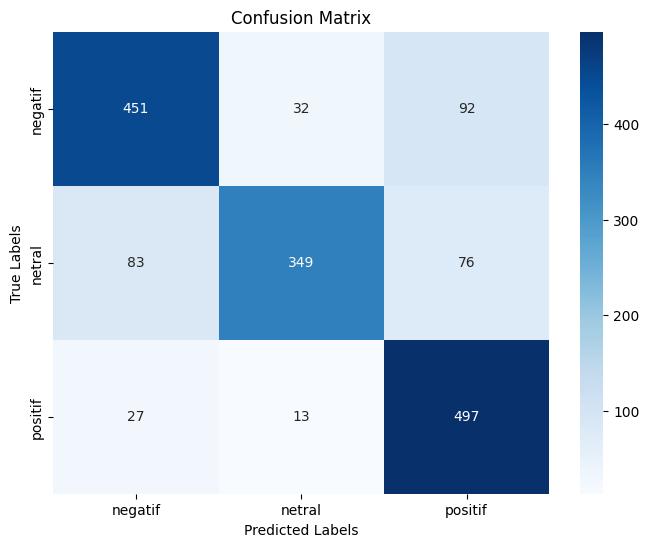

In [17]:
# Plot confusion matrix
plot_confusion_matrix(bow_matrix, label_encoder.classes_)

### Model SVM

In [18]:
from sklearn.svm import SVC

#### Tanpa Paramater

In [19]:
# Initialize Naive Bayes classifier
svm_tanpa_parameter = SVC(kernel='linear', random_state=42)

# Train and evaluate on Bag of Words (BoW) features
bow_accuracy, bow_f1,bow_report,bow_matrix = train_and_evaluate(svm_tanpa_parameter , count_train_features, y_train_encoded, count_test_features, y_test_encoded)

In [20]:
print("Bag of Words (BoW) Features:")
print("Accuracy: {:.2f}%".format(bow_accuracy))
print("F1 Score: {:.2f}%".format(bow_f1))
print("Classification Report:\n", bow_report)
print("Confusion Matrix:\n", bow_matrix)

Bag of Words (BoW) Features:
Accuracy: 84.69%
F1 Score: 84.67%
Classification Report:
               precision    recall  f1-score   support

     negatif       0.86      0.80      0.83       575
      netral       0.82      0.89      0.85       508
     positif       0.87      0.86      0.86       537

    accuracy                           0.85      1620
   macro avg       0.85      0.85      0.85      1620
weighted avg       0.85      0.85      0.85      1620

Confusion Matrix:
 [[462  62  51]
 [ 38 450  20]
 [ 39  38 460]]


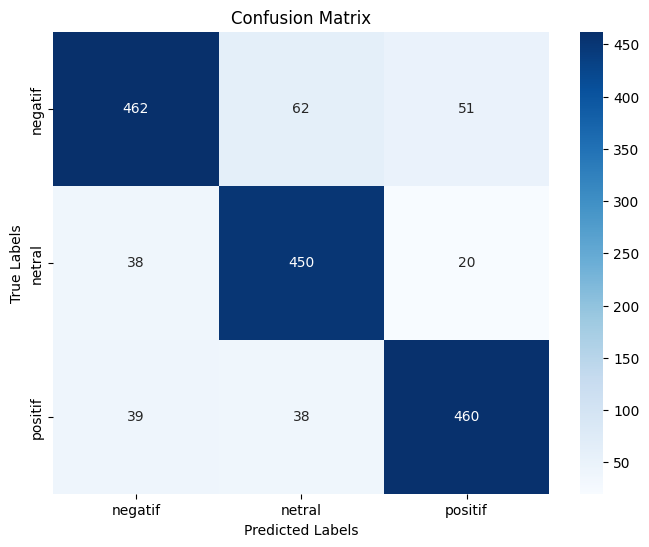

In [21]:
# Plot confusion matrix
plot_confusion_matrix(bow_matrix, label_encoder.classes_)

#### Tuning

In [22]:
# # Define the parameter grid
# param_grid_svm = {'C': [0.1, 1, 10],
#                   'gamma': [0.1, 0.01, 0.001],
#                   'kernel': ['linear', 'rbf', 'sigmoid']}

# # Initialize GridSearchCV
# grid_search_svm = GridSearchCV(svm_tanpa_parameter, param_grid_svm, cv=5, scoring='accuracy')

# # Fit the grid search to the data
# grid_search_svm.fit(count_train_features, y_train_encoded)

# # Get the best parameters
# best_params_svm = grid_search_svm.best_params_
# print("Best Parameters:", best_params_svm)

# # Get the best model
# best_model_svm = grid_search_svm.best_estimator_
# print("Best Parameters:", best_params_svm)

#### Pakai Parameter

In [23]:
# Initialize Naive Bayes classifier
svm_parameter = SVC(C=10,gamma=0.001,kernel='sigmoid', random_state=42)

# Train and evaluate on Bag of Words (BoW) features
bow_accuracy, bow_f1,bow_report,bow_matrix = train_and_evaluate(svm_parameter , count_train_features, y_train_encoded, count_test_features, y_test_encoded)


In [24]:
print("Bag of Words (BoW) Features:")
print("Accuracy: {:.2f}%".format(bow_accuracy))
print("F1 Score: {:.2f}%".format(bow_f1))
print("Classification Report:\n", bow_report)
print("Confusion Matrix:\n", bow_matrix)

Bag of Words (BoW) Features:
Accuracy: 87.10%
F1 Score: 87.08%
Classification Report:
               precision    recall  f1-score   support

     negatif       0.91      0.81      0.86       575
      netral       0.82      0.93      0.87       508
     positif       0.89      0.87      0.88       537

    accuracy                           0.87      1620
   macro avg       0.87      0.87      0.87      1620
weighted avg       0.87      0.87      0.87      1620

Confusion Matrix:
 [[468  63  44]
 [ 20 474  14]
 [ 26  42 469]]


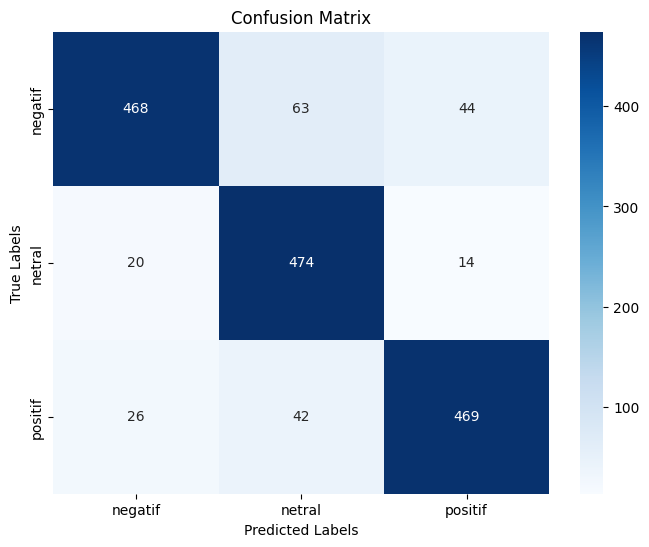

In [25]:
# Plot confusion matrix
plot_confusion_matrix(bow_matrix, label_encoder.classes_)

### Model Logistic Regression

In [26]:
from sklearn.linear_model import LogisticRegression


#### Tanpa Paramater

In [27]:
# Initialize Naive Bayes classifier
lr_tanpa_parameter = LogisticRegression(random_state=42,max_iter=1000)

# Train and evaluate on Bag of Words (BoW) features
bow_accuracy, bow_f1,bow_report,bow_matrix = train_and_evaluate(lr_tanpa_parameter , count_train_features, y_train_encoded, count_test_features, y_test_encoded)


In [28]:
print("Bag of Words (BoW) Features:")
print("Accuracy: {:.2f}%".format(bow_accuracy))
print("F1 Score: {:.2f}%".format(bow_f1))
print("Classification Report:\n", bow_report)
print("Confusion Matrix:\n", bow_matrix)

Bag of Words (BoW) Features:
Accuracy: 87.28%
F1 Score: 87.25%
Classification Report:
               precision    recall  f1-score   support

     negatif       0.89      0.82      0.85       575
      netral       0.84      0.92      0.88       508
     positif       0.89      0.89      0.89       537

    accuracy                           0.87      1620
   macro avg       0.87      0.87      0.87      1620
weighted avg       0.87      0.87      0.87      1620

Confusion Matrix:
 [[470  57  48]
 [ 33 466   9]
 [ 26  33 478]]


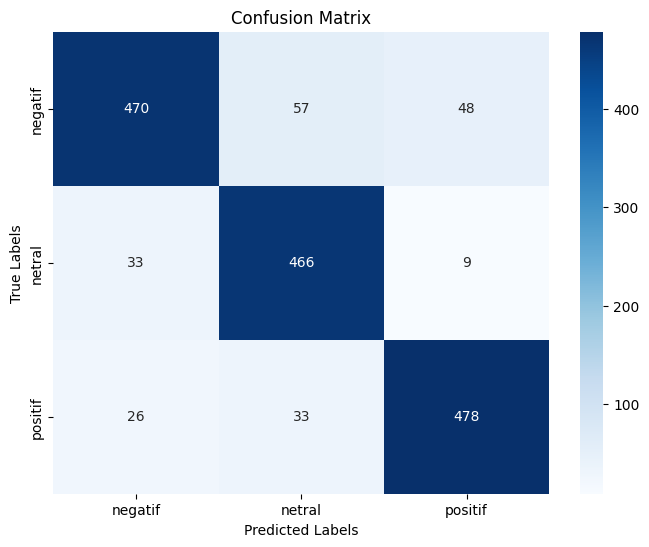

In [29]:
# Plot confusion matrix
plot_confusion_matrix(bow_matrix, label_encoder.classes_)

#### Tuning

In [30]:
# # Define the parameter grid
# param_grid_lr = {'C': [0.001, 0.01, 0.1, 1, 10],
#                  'penalty': ['l1', 'l2'], 
#                   'solver': ['liblinear', 'saga'],
#                   'max_iter': [1000]
#                  }

# # Initialize GridSearchCV
# grid_search_lr = GridSearchCV(lr_tanpa_parameter, param_grid_lr, cv=5, scoring='accuracy')

# # Fit the grid search to the data
# grid_search_lr.fit(count_train_features, y_train_encoded)

# # Get the best parameters
# best_params_lr = grid_search_lr.best_params_
# print("Best Parameters:", best_params_lr)

# # Get the best model
# best_model_lr = grid_search_lr.best_estimator_
# print("Best Parameters:", best_params_lr)


#### Parameter

In [31]:
# Initialize Naive Bayes classifier
lr_parameter =  LogisticRegression(C=0.1,penalty="l2",random_state=42,max_iter=1000,solver='sag')

## Train and evaluate on Bag of Words (BoW) features
bow_accuracy, bow_f1,bow_report,bow_matrix = train_and_evaluate(lr_parameter , count_train_features, y_train_encoded, count_test_features, y_test_encoded)


/home/krisna/ProjectTA/model_ta/env/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [32]:
print("Bag of Words (BoW) Features:")
print("Accuracy: {:.2f}%".format(bow_accuracy))
print("F1 Score: {:.2f}%".format(bow_f1))
print("Classification Report:\n", bow_report)
print("Confusion Matrix:\n", bow_matrix)

Bag of Words (BoW) Features:
Accuracy: 87.65%
F1 Score: 87.62%
Classification Report:
               precision    recall  f1-score   support

     negatif       0.89      0.82      0.86       575
      netral       0.84      0.92      0.88       508
     positif       0.90      0.89      0.89       537

    accuracy                           0.88      1620
   macro avg       0.88      0.88      0.88      1620
weighted avg       0.88      0.88      0.88      1620

Confusion Matrix:
 [[472  55  48]
 [ 32 469   7]
 [ 25  33 479]]


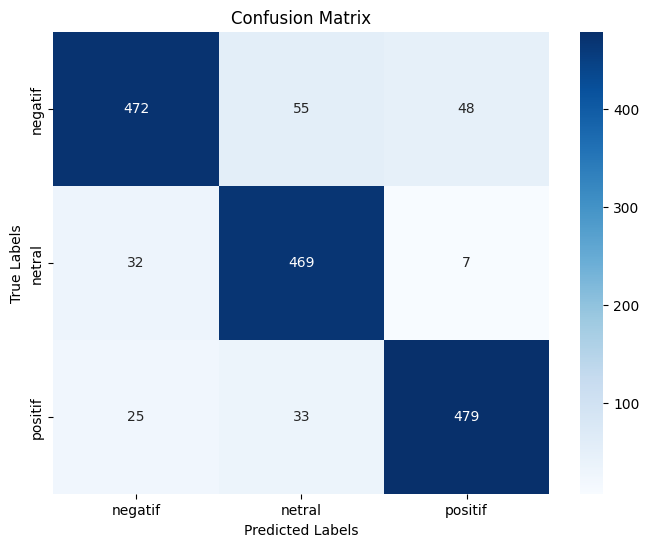

In [33]:
# Plot confusion matrix
plot_confusion_matrix(bow_matrix, label_encoder.classes_)

### Model Random Forest

In [34]:
from sklearn.ensemble import RandomForestClassifier

#### Tanpa Paramater

In [35]:
# Initialize Naive Bayes classifier
rfc_tanpa_parameter = RandomForestClassifier(random_state=42)

# Train and evaluate on Bag of Words (BoW) features
bow_accuracy, bow_f1,bow_report,bow_matrix = train_and_evaluate(rfc_tanpa_parameter, count_train_features, y_train_encoded, count_test_features, y_test_encoded)


In [36]:
print("Bag of Words (BoW) Features:")
print("Accuracy: {:.2f}%".format(bow_accuracy))
print("F1 Score: {:.2f}%".format(bow_f1))
print("Classification Report:\n", bow_report)
print("Confusion Matrix:\n", bow_matrix)

Bag of Words (BoW) Features:
Accuracy: 82.65%
F1 Score: 82.31%
Classification Report:
               precision    recall  f1-score   support

     negatif       0.88      0.68      0.77       575
      netral       0.82      0.92      0.86       508
     positif       0.80      0.89      0.84       537

    accuracy                           0.83      1620
   macro avg       0.83      0.83      0.83      1620
weighted avg       0.83      0.83      0.82      1620

Confusion Matrix:
 [[392  72 111]
 [ 30 467  11]
 [ 23  34 480]]


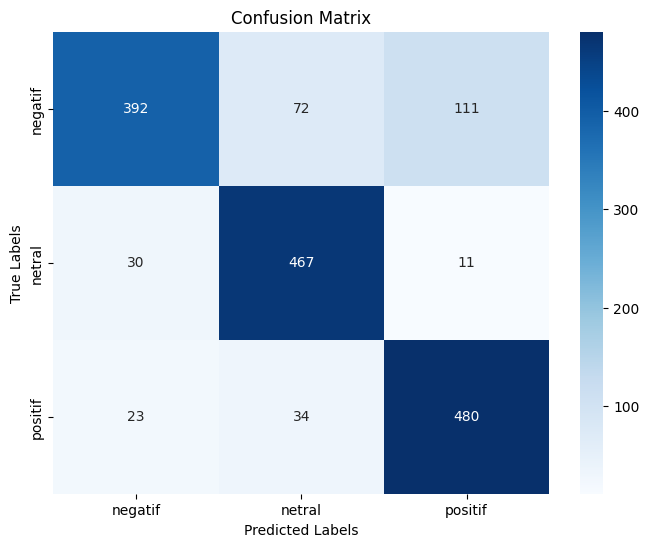

In [37]:
# Plot confusion matrix
plot_confusion_matrix(bow_matrix, label_encoder.classes_)

### Tuning

In [38]:
# # Define the parameter grid
# param_grid_rfc = {'n_estimators': [50, 100, 200],
#                   'max_depth': [None, 10, 20, 30],
#                   'min_samples_split': [2, 5, 10]}

# # Initialize GridSearchCV
# grid_search_rfc = GridSearchCV(rfc_tanpa_parameter, param_grid_rfc, cv=5, scoring='accuracy')

# # Fit the grid search to the data
# grid_search_rfc.fit(count_train_features, y_train_encoded)

# # Get the best parameters
# best_params_rfc = grid_search_rfc.best_params_
# print("Best Parameters:", best_params_rfc)

# # Get the best model
# best_model_rfc = grid_search_rfc.best_estimator_
# print("Best Parameters:", best_model_rfc)

#### Paramater

In [39]:
# Initialize Naive Bayes classifier
rfc_parameter = RandomForestClassifier(min_samples_split=2,n_estimators=100)

# Train and evaluate on Bag of Words (BoW) features
bow_accuracy, bow_f1,bow_report,bow_matrix = train_and_evaluate(rfc_tanpa_parameter, count_train_features, y_train_encoded, count_test_features, y_test_encoded)


In [40]:
print("Bag of Words (BoW) Features:")
print("Accuracy: {:.2f}%".format(bow_accuracy))
print("F1 Score: {:.2f}%".format(bow_f1))
print("Classification Report:\n", bow_report)
print("Confusion Matrix:\n", bow_matrix)

Bag of Words (BoW) Features:
Accuracy: 82.65%
F1 Score: 82.31%
Classification Report:
               precision    recall  f1-score   support

     negatif       0.88      0.68      0.77       575
      netral       0.82      0.92      0.86       508
     positif       0.80      0.89      0.84       537

    accuracy                           0.83      1620
   macro avg       0.83      0.83      0.83      1620
weighted avg       0.83      0.83      0.82      1620

Confusion Matrix:
 [[392  72 111]
 [ 30 467  11]
 [ 23  34 480]]


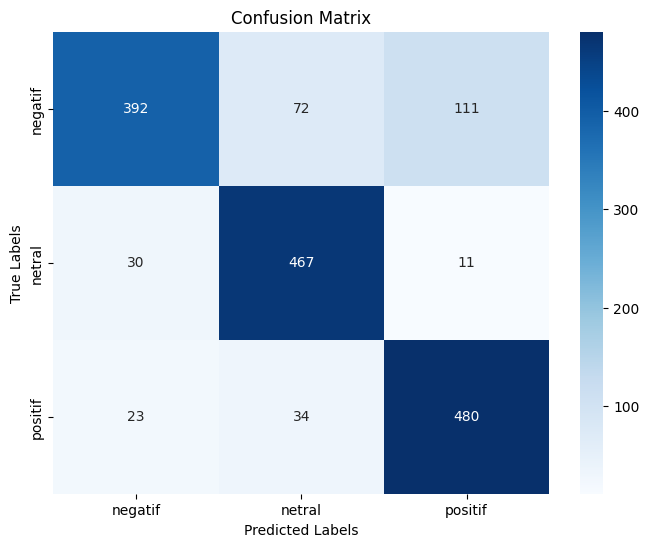

In [41]:
# Plot confusion matrix
plot_confusion_matrix(bow_matrix, label_encoder.classes_)

### Model Ensemble Learning

In [42]:
# Mengambil model terbaik dari hasil tuning
best_model_naive_bayes = model_naiye_parameter
best_model_svm = svm_parameter
best_model_random_forest = rfc_parameter
best_model_logistic_regression = lr_parameter

In [43]:
from sklearn.ensemble import VotingClassifier

#### Model Gabungin 4 Model

In [44]:
# Membuat model ensemble
ensemble_model_4 = VotingClassifier(estimators=[
    ('naive_bayes', best_model_naive_bayes),
    ('svm', best_model_svm),
    ('random_forest', best_model_random_forest),
    ('logistic_regression', best_model_logistic_regression)
], voting='hard')

# Train and evaluate on Bag of Words (BoW) features
bow_accuracy, bow_f1,bow_report,bow_matrix = train_and_evaluate(ensemble_model_4, count_train_features, y_train_encoded, count_test_features, y_test_encoded)

/home/krisna/ProjectTA/model_ta/env/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [45]:
print("Bag of Words (BoW) Features:")
print("Accuracy: {:.2f}%".format(bow_accuracy))
print("F1 Score: {:.2f}%".format(bow_f1))
print("Classification Report:\n", bow_report)
print("Confusion Matrix:\n", bow_matrix)

Bag of Words (BoW) Features:
Accuracy: 87.47%
F1 Score: 87.45%
Classification Report:
               precision    recall  f1-score   support

     negatif       0.88      0.83      0.85       575
      netral       0.84      0.92      0.88       508
     positif       0.91      0.88      0.89       537

    accuracy                           0.87      1620
   macro avg       0.88      0.88      0.88      1620
weighted avg       0.88      0.87      0.87      1620

Confusion Matrix:
 [[480  50  45]
 [ 37 467   4]
 [ 31  36 470]]


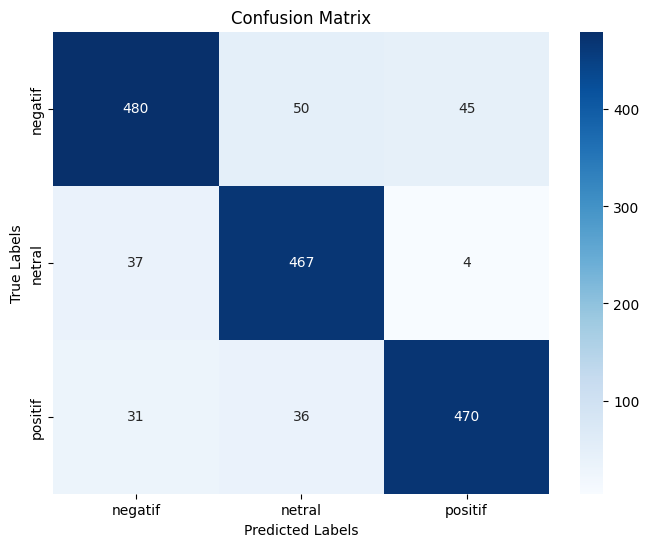

In [46]:
# Plot confusion matrix
plot_confusion_matrix(bow_matrix, label_encoder.classes_)

#### Model 3 dengan Akurasi Terbaik

In [47]:
# Membuat model ensemble
ensemble_model_3 = VotingClassifier(estimators=[
    ('svm', best_model_svm),
    ('random_forest', best_model_random_forest),
    ('logistic_regression', best_model_logistic_regression)
], voting='hard')

# Train and evaluate on Bag of Words (BoW) features
bow_accuracy, bow_f1,bow_report,bow_matrix = train_and_evaluate(ensemble_model_3, count_train_features, y_train_encoded, count_test_features, y_test_encoded)

/home/krisna/ProjectTA/model_ta/env/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [48]:
print("Bag of Words (BoW) Features:")
print("Accuracy: {:.2f}%".format(bow_accuracy))
print("F1 Score: {:.2f}%".format(bow_f1))
print("Classification Report:\n", bow_report)
print("Confusion Matrix:\n", bow_matrix)

Bag of Words (BoW) Features:
Accuracy: 88.15%
F1 Score: 88.10%
Classification Report:
               precision    recall  f1-score   support

     negatif       0.91      0.82      0.86       575
      netral       0.84      0.94      0.89       508
     positif       0.89      0.89      0.89       537

    accuracy                           0.88      1620
   macro avg       0.88      0.88      0.88      1620
weighted avg       0.88      0.88      0.88      1620

Confusion Matrix:
 [[469  56  50]
 [ 22 479   7]
 [ 22  35 480]]


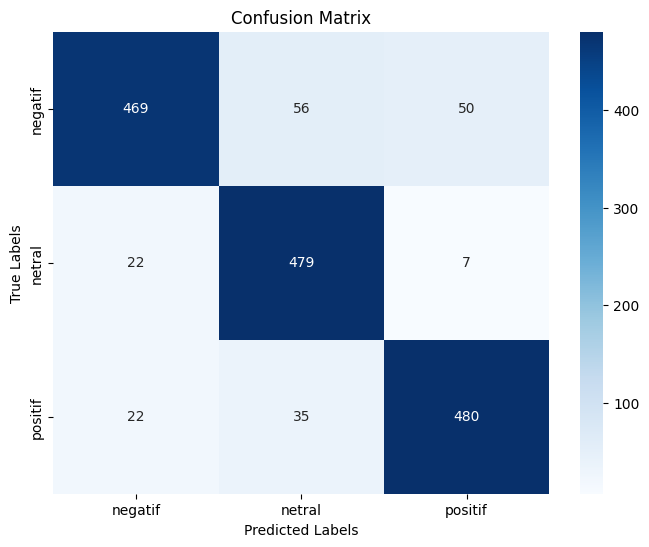

In [49]:
# Plot confusion matrix
plot_confusion_matrix(bow_matrix, label_encoder.classes_)

#### Model 2 Dengan Nilai Akurasi Terbaik 

In [50]:
# Membuat model ensemble
ensemble_model_2 = VotingClassifier(estimators=[
    ('svm', best_model_svm),
    ('logistic_regression', best_model_logistic_regression)
], voting='hard')

# Train and evaluate on Bag of Words (BoW) features
bow_accuracy, bow_f1,bow_report,bow_matrix = train_and_evaluate(ensemble_model_2, count_train_features, y_train_encoded, count_test_features, y_test_encoded)

/home/krisna/ProjectTA/model_ta/env/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [51]:
print("Bag of Words (BoW) Features:")
print("Accuracy: {:.2f}%".format(bow_accuracy))
print("F1 Score: {:.2f}%".format(bow_f1))
print("Classification Report:\n", bow_report)
print("Confusion Matrix:\n", bow_matrix)

Bag of Words (BoW) Features:
Accuracy: 86.98%
F1 Score: 86.98%
Classification Report:
               precision    recall  f1-score   support

     negatif       0.87      0.85      0.86       575
      netral       0.83      0.91      0.87       508
     positif       0.91      0.85      0.88       537

    accuracy                           0.87      1620
   macro avg       0.87      0.87      0.87      1620
weighted avg       0.87      0.87      0.87      1620

Confusion Matrix:
 [[486  48  41]
 [ 38 464   6]
 [ 33  45 459]]


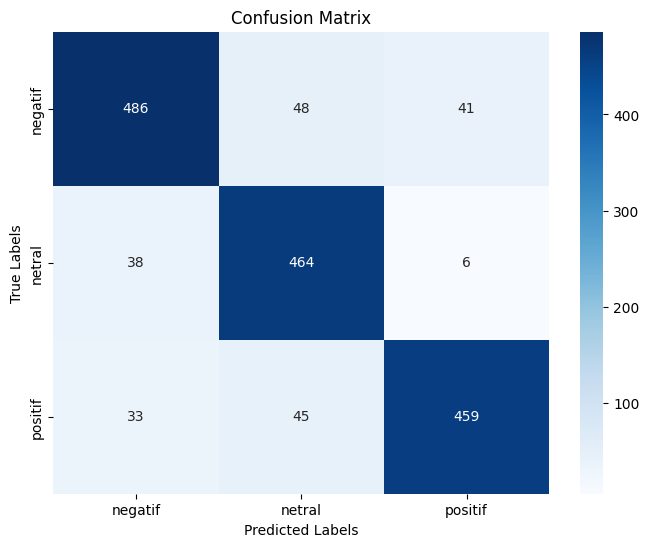

In [52]:
# Plot confusion matrix
plot_confusion_matrix(bow_matrix, label_encoder.classes_)

In [53]:
import joblib
# # Dictionary to store model and vectorizer
# model_data = {
#     'model': ensemble_model_4,  # your trained Logistic Regression model
#     'vectorizer': count_vectorizer,
#     'label_encoder': label_encoder
# }

# # Save the model data to a file
# joblib.dump(model_data, 'gabungan_4model.pkl')

In [54]:
# Later, to load the model data from the file
loaded_model_data = joblib.load('gabungan_4model.pkl')

# Extract model and vectorizer from loaded data
loaded_model = loaded_model_data['model']
loaded_vectorizer = loaded_model_data['vectorizer']
new_data = ["bogor keluarga fw 22 perempuan dibunuh pacarnya ra alias alung 20 bogor pelaku dihukum berat ayah korban iwan irawan terima alung dihukum 15 tahun penjara sesuai pasal 338 kuhp pembunuhan iwan berharap alung dihukum seberat beratnya penjara seumur hidup baca wanita dibunuh pacarnya bogor mulutnya dibekap hidungnya digigit kepolisian hukum seberat beratnya seadil adilnya nyawa anak keberatan 15 tahun harapannya seumur hidup iwan ditemui mapolresta bogor kota selasa 5 12 2023 iwan menyangka kekasih anaknya pelaku pembunuh darah dagingnya hubungan asmara terjalin tahun setahun kenal dianggap anak main rumah iwan timbal baliknya bohong anak meninggal jatuh motor dibunuh sambung baca bekap pacar tewas bogor pelaku niat membunuhsejak peristiwa tragis iwan keluarga tersangka iktikad pemakaman anaknya keluarga tersangka keluarga tersangka iktikad baiknya ga komunikasinya iwan nyawa aja pertemuan pemakaman sambung", 
            "calon presiden bacapres ganjar pranowo mengawali aktivitasnya berlari seputaran kota bandung jawa barat pria berambut putih menyusuri gang gang pemukiman warga"]

# Extract model, vectorizer, and label encoder from loaded data
loaded_model = loaded_model_data['model']
loaded_vectorizer = loaded_model_data['vectorizer']
loaded_label_encoder = loaded_model_data['label_encoder']

# Vectorize the new data using the loaded CountVectorizer
new_data_features = loaded_vectorizer.transform(new_data)

# Predict sentiment using the loaded model
predictions = loaded_model.predict(new_data_features)

# Decode numerical labels back to text labels using the loaded LabelEncoder
predicted_sentiments = loaded_label_encoder.inverse_transform(predictions)

# Print the predicted sentiments
for text, sentiment in zip(new_data, predicted_sentiments):
    print(f"Text: '{text}' -> Predicted Sentiment: '{sentiment}'")

Text: 'bogor keluarga fw 22 perempuan dibunuh pacarnya ra alias alung 20 bogor pelaku dihukum berat ayah korban iwan irawan terima alung dihukum 15 tahun penjara sesuai pasal 338 kuhp pembunuhan iwan berharap alung dihukum seberat beratnya penjara seumur hidup baca wanita dibunuh pacarnya bogor mulutnya dibekap hidungnya digigit kepolisian hukum seberat beratnya seadil adilnya nyawa anak keberatan 15 tahun harapannya seumur hidup iwan ditemui mapolresta bogor kota selasa 5 12 2023 iwan menyangka kekasih anaknya pelaku pembunuh darah dagingnya hubungan asmara terjalin tahun setahun kenal dianggap anak main rumah iwan timbal baliknya bohong anak meninggal jatuh motor dibunuh sambung baca bekap pacar tewas bogor pelaku niat membunuhsejak peristiwa tragis iwan keluarga tersangka iktikad pemakaman anaknya keluarga tersangka keluarga tersangka iktikad baiknya ga komunikasinya iwan nyawa aja pertemuan pemakaman sambung' -> Predicted Sentiment: 'negatif'
Text: 'calon presiden bacapres ganjar p